In [1]:
import pandas as pd
import numpy as np
import csv
import statsmodels.api as sm
import os

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
import dotenv

# Load the environment variables
# (loads CENSUS_API_KEY from .env)
dotenv.load_dotenv()

False

In [4]:
%%R
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In addition: Warning messages:
1: package ‘readr’ was built under R version 4.2.3 
2: package ‘dplyr’ was built under R version 4.2.3 
3: package ‘stringr’ was built under R version 4.2.3 


In [5]:
# Open the file and turn it into a pandas dataframe
df = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

# Show the first 5 rows of the dataframe
print(df.head())

   RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     91982         1       77494        zip        TX    TX      Katy   
1     61148         2        8701        zip        NJ    NJ  Lakewood   
2     91940         3       77449        zip        TX    TX      Katy   
3     62080         4       11368        zip        NY    NY  New York   
4     91733         5       77084        zip        TX    TX   Houston   

                                   Metro        CountyName     2000-01-31  \
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  210077.000246   
1  New York-Newark-Jersey City, NY-NJ-PA      Ocean County  137227.265500   
2   Houston-The Woodlands-Sugar Land, TX     Harris County  103358.701090   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  146558.052897   
4   Houston-The Woodlands-Sugar Land, TX     Harris County  102016.821579   

   ...     2023-05-31     2023-06-30     2023-07-31     2023-08-31  \
0  ...  474580.751007 

In [6]:
# Print the column names
print(df.columns)

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000-01-31',
       ...
       '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
       '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31', '2024-02-29'],
      dtype='object', length=299)


In [7]:
# Keep only data with State as MA
df = df[df['State'] == 'MA']

# Keep only columns including RegionName, StateName, City, Metro, CountyName, 31/12/2018, 31/12/2019, 31/12/2022, 31/12/2023
df = df[['RegionName', 'StateName', 'City', 'Metro', 'CountyName', '2018-12-31', '2019-12-31', '2022-12-31', '2023-12-31']]

In [8]:
# Ditch the rows with NaN values
df = df.dropna()

# Show how many rows are left
print(df.shape)

(477, 9)


In [9]:
df['RegionName'] = df['RegionName'].astype(str).str.zfill(5)

In [10]:
# Show the first 5 rows of RegionName
print(df['RegionName'].head())

242    02301
307    02148
419    02155
457    02151
537    02169
Name: RegionName, dtype: object


In [11]:
# Store all the RegionNames in a list
ma_zips = df['RegionName'].tolist()

In [12]:
%%R 

require('tidycensus')

# because it an environment variable, we don't have to 
# explicitly pass this string to R, it is readable here
# in this R cell.
census_api_key(Sys.getenv("97779d587a8fdba4e4f7f7d3eec838313d5b07ab"))

Loading required package: tidycensus
To install your API key for use in future sessions, run this function with `install = TRUE`.
In addition: Warning message:
package ‘tidycensus’ was built under R version 4.2.3 


In [13]:
%%R 
# Get variable from ACS
ma_census_data_2022 <- get_acs(geography = "zip code tabulation area",
                      variables = c(
                        total_population_2022 = "B01003_001",
                        median_room_2022 = "B25018_001",
                        median_built_2022 = "B25035_001",
                        median_income_2022 = "B06011_001",
                        bachelor_2022 = "B15003_022",
                        asian_2022 = "B03002_006", 
                        black_2022 = "B03002_004",
                        hispanic_2022 = "B03002_012"
                      ), 
                      year = 2022,
                      survey="acs5",
                      geometry=F)
ma_census_data_2022

# A tibble: 270,192 × 5
   GEOID NAME        variable              estimate   moe
   <chr> <chr>       <chr>                    <dbl> <dbl>
 1 00601 ZCTA5 00601 total_population_2022    16834   506
 2 00602 ZCTA5 00602 total_population_2022    37642   205
 3 00603 ZCTA5 00603 total_population_2022    49075   963
 4 00606 ZCTA5 00606 total_population_2022     5590   264
 5 00610 ZCTA5 00610 total_population_2022    25542   344
 6 00611 ZCTA5 00611 total_population_2022     1315   382
 7 00612 ZCTA5 00612 total_population_2022    63312  1805
 8 00616 ZCTA5 00616 total_population_2022     9625  1319
 9 00617 ZCTA5 00617 total_population_2022    22573   241
10 00622 ZCTA5 00622 total_population_2022     7577   979
# ℹ 270,182 more rows
# ℹ Use `print(n = ...)` to see more rows


Getting data from the 2018-2022 5-year ACS
In addition: Warning message:
• You have not set a Census API key. Users without a key are limited to 500
queries per day and may experience performance limitations.
ℹ For best results, get a Census API key at
http://api.census.gov/data/key_signup.html and then supply the key to the
`census_api_key()` function to use it throughout your tidycensus session.
This warning is displayed once per session. 


In [14]:
%R -i ma_zips

ma_zips

['02301',
 '02148',
 '02155',
 '02151',
 '02169',
 '02124',
 '01960',
 '02360',
 '02780',
 '01844',
 '01841',
 '02149',
 '01902',
 '02740',
 '02703',
 '02128',
 '01201',
 '02135',
 '01970',
 '01453',
 '01420',
 '01085',
 '01915',
 '01752',
 '02130',
 '01801',
 '02150',
 '01604',
 '02136',
 '01040',
 '02139',
 '02184',
 '02138',
 '01545',
 '01852',
 '01702',
 '01760',
 '01810',
 '02302',
 '02127',
 '02368',
 '02472',
 '01701',
 '02038',
 '02125',
 '01845',
 '02131',
 '01826',
 '01851',
 '02062',
 '01821',
 '01876',
 '02446',
 '01605',
 '01109',
 '02453',
 '01757',
 '01020',
 '01930',
 '02121',
 '02720',
 '02176',
 '02760',
 '01906',
 '02072',
 '02115',
 '02324',
 '02119',
 '01002',
 '01089',
 '02118',
 '01854',
 '02474',
 '02186',
 '02145',
 '01923',
 '01830',
 '01843',
 '01824',
 '01880',
 '02478',
 '02144',
 '02132',
 '01108',
 '01602',
 '02721',
 '01905',
 '01803',
 '02126',
 '01104',
 '02050',
 '02143',
 '02026',
 '01867',
 '02215',
 '01832',
 '02745',
 '01606',
 '01886',
 '01610',


In [15]:
%%R
# Remove the "ZCTA5 " prefix from the NAME column
ma_census_data_2022$NAME <- sub("ZCTA5 ", "", ma_census_data_2022$NAME)

# Show the first 5 rows of the ma_census_data_2022 dataframe
head(ma_census_data_2022)

# A tibble: 6 × 5
  GEOID NAME  variable              estimate   moe
  <chr> <chr> <chr>                    <dbl> <dbl>
1 00601 00601 total_population_2022    16834   506
2 00602 00602 total_population_2022    37642   205
3 00603 00603 total_population_2022    49075   963
4 00606 00606 total_population_2022     5590   264
5 00610 00610 total_population_2022    25542   344
6 00611 00611 total_population_2022     1315   382


In [16]:
%%R
# Keep only the rows with RegionName in ma_zips
ma_census_data_2022 <- ma_census_data_2022[ma_census_data_2022$NAME %in% ma_zips,]

# Show the first 5 rows of the ma_census_data_2022 dataframe
head(ma_census_data_2022)

# A tibble: 6 × 5
  GEOID NAME  variable              estimate   moe
  <chr> <chr> <chr>                    <dbl> <dbl>
1 01001 01001 total_population_2022    16045   946
2 01002 01002 total_population_2022    22992   308
3 01005 01005 total_population_2022     4837   465
4 01007 01007 total_population_2022    15368    59
5 01008 01008 total_population_2022     1231   218
6 01010 01010 total_population_2022     3699    20


In [17]:
%%R
# Ditch NAME and moe columns
ma_census_data_2022 <- ma_census_data_2022 %>%
  select(-NAME, -moe)

In [18]:
%%R
# Convert the long format to wide format
ma_census_data_2022_wide <- ma_census_data_2022 %>%
  pivot_wider(
    names_from = variable,  # Column that contains variable names
    values_from = estimate  # Column that contains the values
  )

# Show the first 5 rows of the ma_census_data_2022 dataframe
head(ma_census_data_2022_wide)

# A tibble: 6 × 9
  GEOID total_population_2022 median_room_2022 median_built_2022
  <chr>                 <dbl>            <dbl>             <dbl>
1 01001                 16045              5.4              1970
2 01002                 22992              5.4              1974
3 01005                  4837              6.5              1965
4 01007                 15368              6.1              1985
5 01008                  1231              6.2              1962
6 01010                  3699              6.2              1987
# ℹ 5 more variables: median_income_2022 <dbl>, bachelor_2022 <dbl>,
#   asian_2022 <dbl>, black_2022 <dbl>, hispanic_2022 <dbl>


In [19]:
%%R
df <- read.csv("Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

# Fill the RegionName to 5 digits
df$RegionName <- as.character(df$RegionName)
df$RegionName <- sprintf("%05s", df$RegionName)

# Keep only data with State as MA
df <- df[df$State == 'MA',]

# Show the first 5 rows of the dataframe
head(df)

    RegionID SizeRank RegionName RegionType StateName State     City
243    58710      248      02301        zip        MA    MA Brockton
308    58660      314      02148        zip        MA    MA   Malden
420    58666      429      02155        zip        MA    MA  Medford
458    58663      467      02151        zip        MA    MA   Revere
538    58669      547      02169        zip        MA    MA   Quincy
572    58638      581      02124        zip        MA    MA   Boston
                             Metro       CountyName X2000.01.31 X2000.02.29
243 Boston-Cambridge-Newton, MA-NH  Plymouth County    123618.3    122878.0
308 Boston-Cambridge-Newton, MA-NH Middlesex County    165486.9    166120.3
420 Boston-Cambridge-Newton, MA-NH Middlesex County    210739.7    211898.6
458 Boston-Cambridge-Newton, MA-NH   Suffolk County    151737.3    152400.3
538 Boston-Cambridge-Newton, MA-NH   Norfolk County    167384.5    167897.6
572 Boston-Cambridge-Newton, MA-NH   Suffolk County    135887

In [20]:
%%R
# How many rows are left
nrow(df)

[1] 485


In [21]:
%%R

# Append the X2022.12.31 column to the ma_census_data_2022_wide dataframe
# With RegionName in df matching GEOID in ma_census_data_2022_wide. Only keep the rows with a match.

ma_census_data_2022_wide <- ma_census_data_2022_wide %>%
    inner_join(df, by = c('GEOID' = 'RegionName'))

# Show the first 5 rows of the ma_census_data_2022_wide dataframe
head(ma_census_data_2022_wide)

# A tibble: 6 × 307
  GEOID total_population_2022 median_room_2022 median_built_2022
  <chr>                 <dbl>            <dbl>             <dbl>
1 01001                 16045              5.4              1970
2 01002                 22992              5.4              1974
3 01005                  4837              6.5              1965
4 01007                 15368              6.1              1985
5 01008                  1231              6.2              1962
6 01010                  3699              6.2              1987
# ℹ 303 more variables: median_income_2022 <dbl>, bachelor_2022 <dbl>,
#   asian_2022 <dbl>, black_2022 <dbl>, hispanic_2022 <dbl>, RegionID <int>,
#   SizeRank <int>, RegionType <chr>, StateName <chr>, State <chr>, City <chr>,
#   Metro <chr>, CountyName <chr>, X2000.01.31 <dbl>, X2000.02.29 <dbl>,
#   X2000.03.31 <dbl>, X2000.04.30 <dbl>, X2000.05.31 <dbl>, X2000.06.30 <dbl>,
#   X2000.07.31 <dbl>, X2000.08.31 <dbl>, X2000.09.30 <dbl>, X2000.10.31 <dbl>,

In [22]:
%%R

# Create a new column named bachelor_rate_2022, which is the ratio of bachelor_2022 to total_population_2022
ma_census_data_2022_wide <- ma_census_data_2022_wide %>%
    mutate(bachelor_rate_2022 = bachelor_2022 / total_population_2022)

# Create a new column named asian_rate_2022, which is the ratio of asian_2022 to total_population_2022
ma_census_data_2022_wide <- ma_census_data_2022_wide %>%
    mutate(asian_rate_2022 = asian_2022 / total_population_2022)

# Create a new column named black_rate_2022, which is the ratio of black_2022 to total_population_2022
ma_census_data_2022_wide <- ma_census_data_2022_wide %>%
    mutate(black_rate_2022 = black_2022 / total_population_2022)

# Create a new column named hispanic_rate_2022, which is the ratio of hispanic_2022 to total_population_2022
ma_census_data_2022_wide <- ma_census_data_2022_wide %>%
    mutate(hispanic_rate_2022 = hispanic_2022 / total_population_2022)

In [23]:
%%R

# Create a new df, which includes the following columns from ma_census_data_2022_wide:
# GEOID, total_population_2022, median_room_2022, median_built_2022, median_income_2022, bachelor_rate_2022, asian_rate_2022, black_rate_2022, hispanic_rate_2022, X2022.12.31
df_final <- ma_census_data_2022_wide %>%
    select(GEOID, total_population_2022, median_room_2022, median_built_2022, median_income_2022, bachelor_rate_2022, asian_rate_2022, black_rate_2022, hispanic_rate_2022, X2022.12.31)

# Show the first 5 rows of the df_final dataframe
head(df_final)

# A tibble: 6 × 10
  GEOID total_population_2022 median_room_2022 median_built_2022
  <chr>                 <dbl>            <dbl>             <dbl>
1 01001                 16045              5.4              1970
2 01002                 22992              5.4              1974
3 01005                  4837              6.5              1965
4 01007                 15368              6.1              1985
5 01008                  1231              6.2              1962
6 01010                  3699              6.2              1987
# ℹ 6 more variables: median_income_2022 <dbl>, bachelor_rate_2022 <dbl>,
#   asian_rate_2022 <dbl>, black_rate_2022 <dbl>, hispanic_rate_2022 <dbl>,
#   X2022.12.31 <dbl>


In [24]:
%%R

# Run a multiple linear regression model with X2022.12.31 as the dependent variable
# and the other columns as the independent variables

model <- lm(X2022.12.31 ~ total_population_2022 + median_room_2022 + median_built_2022 + median_income_2022 + bachelor_rate_2022 + asian_rate_2022 + black_rate_2022 + hispanic_rate_2022, data = df_final)

# Show the summary of the model
summary(model)


Call:
lm(formula = X2022.12.31 ~ total_population_2022 + median_room_2022 + 
    median_built_2022 + median_income_2022 + bachelor_rate_2022 + 
    asian_rate_2022 + black_rate_2022 + hispanic_rate_2022, data = df_final)

Residuals:


    Min      1Q  Median      3Q     Max 
-773672 -124786  -39412   68353 2626044 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            3.560e+06  1.800e+06   1.977   0.0486 *  
total_population_2022 -1.342e+00  1.051e+00  -1.277   0.2022    
median_room_2022       6.640e+03  1.393e+04   0.477   0.6339    
median_built_2022     -1.886e+03  9.173e+02  -2.056   0.0403 *  
median_income_2022     8.909e+00  1.156e+00   7.704 7.95e-14 ***
bachelor_rate_2022     1.095e+06  2.620e+05   4.178 3.51e-05 ***
asian_rate_2022        9.253e+05  1.950e+05   4.744 2.78e-06 ***
black_rate_2022        3.457e+05  1.821e+05   1.898   0.0583 .  
hispanic_rate_2022     2.059e+04  1.243e+05   0.166   0.8685    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 252100 on 468 degrees of freedom
Multiple R-squared:  0.4313,	Adjusted R-squared:  0.4216 
F-statistic: 44.37 on 8 and 468 DF,  p-value: < 2.2e-16



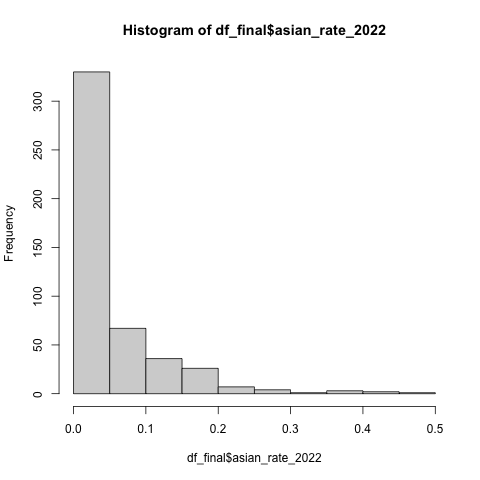

In [25]:
%%R

# Create a histogram of asian_rate_2022
hist(df_final$asian_rate_2022)